In [21]:
%load_ext autoreload
%autoreload 2
from tide_analytics import TidalArea, TidalSeries
import mikeio
from pathlib import Path
import pandas as pd

from tide_analytics.helpers import NonMatchingSlackError

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### User input

In [22]:
FILE = Path("tide_analytics/tests/data/example.dfsu")

### Load .dfsu File

The DFSU file should contain arrays for the following:  
- **Surface elevation**  
- **Current speed**  
- **Current direction**  

Optionally, the **u** and **v** velocity components can be supplied instead of the current speed and direction.  

The **current direction** can be provided in either **degrees** or **radians**.  


<mikeio.Dataset>
dims: (time:282, element:4963)
time: 2022-06-25 01:00:00 - 2022-06-26 23:50:00 (282 records)
geometry: Dfsu2D (4963 elements, 2999 nodes)
items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  Current speed <Current Speed> (meter per sec)
  2:  Current direction <Current Direction> (radian)


<Axes: title={'center': 'Bathymetry'}, xlabel='Easting [m]', ylabel='Northing [m]'>

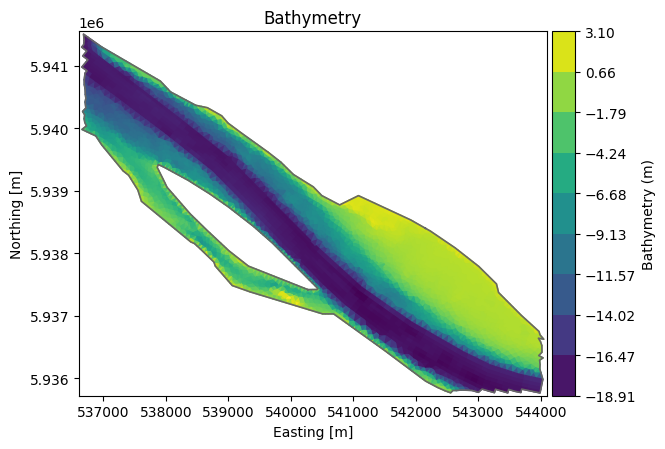

In [23]:
ds = mikeio.read(FILE)
print(ds)
ds.geometry.plot()

### Performing Tidal Analysis on the entire .dfsu Dataset

To perform tidal analysis on a DFSU dataset, you need to provide the following inputs:  
- **Surface elevation**  
- **Current speed**  
- **Current direction**  

The analysis is carried out for each element in the DFSU file. If an unexpected issue occurs during the analysis of an individual element, an error will be raised. However, to prevent interruptions in the calculation process, you can suppress specific errors using the `ignore_error_types` argument.  

Options for `ignore_error_types`:  
- **`"all"`**: Suppresses all possible errors.  
- **`"all_tidal"`**: Suppresses all tide-specific errors. These are custom errors defined by the library for tidal analysis.  
- **A list of error types**: Allows you to specify which errors to suppress.

Once the analysis is complete, it will:  
1. Output an **Error Overview** prompt. (`tidal_area.error_support_prompt()`)
2. **Plot an error map** to visualize where issues occurred.  (`tidal_area.plot_errormap()`)
3. Generate a **statistical summary** of all calculated tidal characteristics. (`tidal_area.plot_statistical_summary()`)

  0%|          | 0/4963 [00:00<?, ?it/s]


Error Overview:
FallsPartiallyDryError     286   5.8 %
FallsPartiallyWetError       4   0.1 %
FallsWetError               44   0.9 %
NonAlternatingHWLWsError     0   0.0 %
NotEnoughWaterError       1270  25.6 %
NotEnoughTidesError          0   0.0 %
NonMatchingSlackError     1205  24.3 %
CurrentsToNoisyError         0   0.0 %
UnknownError                 0   0.0 %
Total Errors              2809  56.6 %


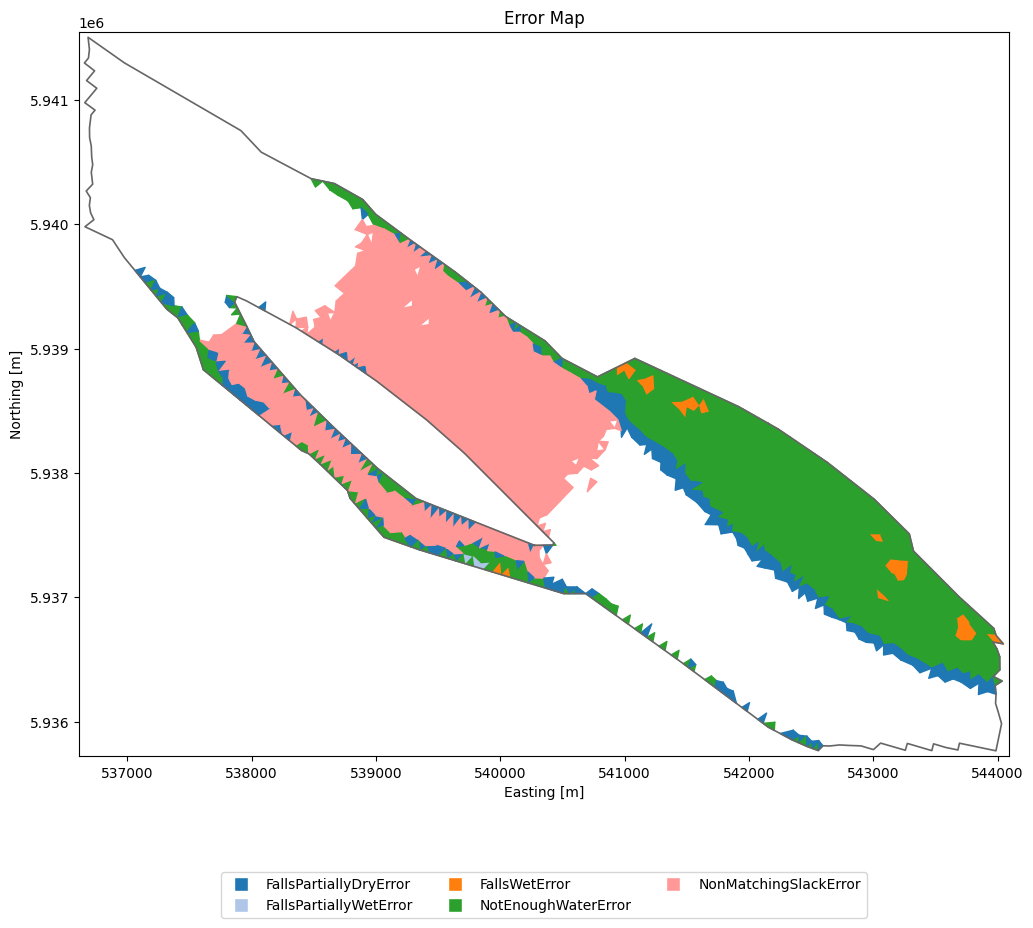

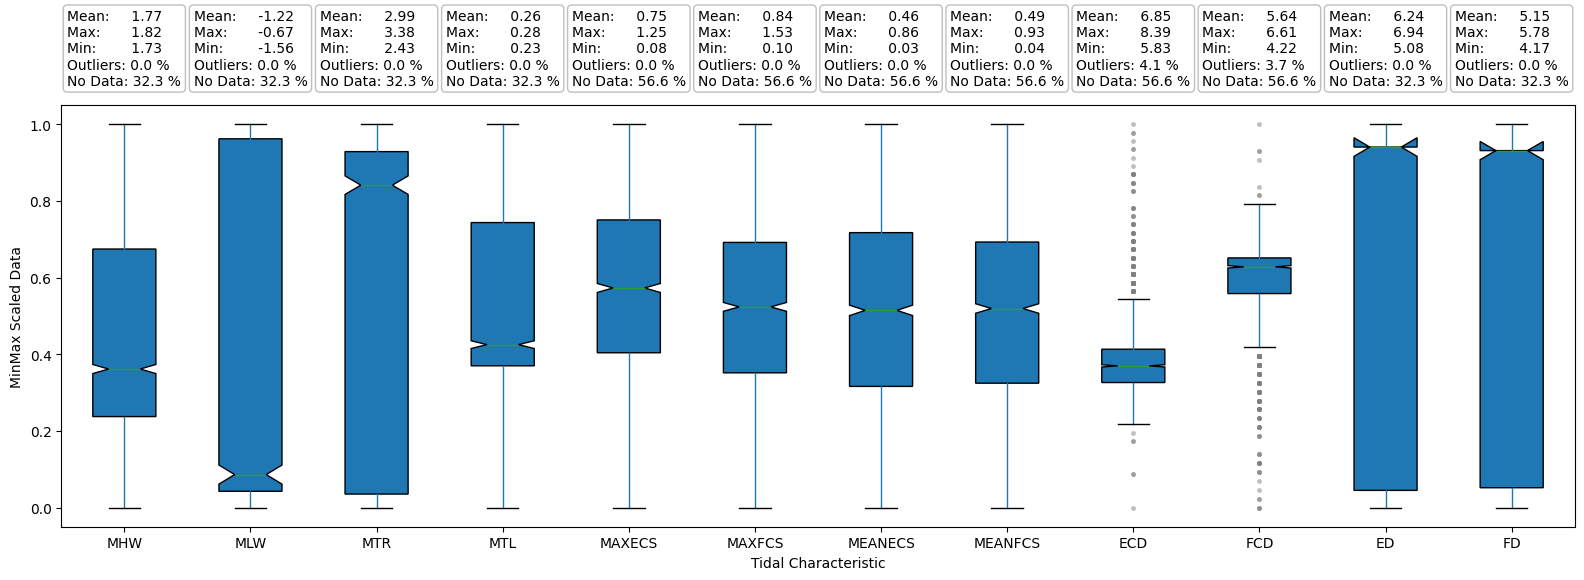

In [24]:
tidal_area = TidalArea(identifier = "example",
                    surface_elevation = ds.Surface_elevation,
                    current_speed = ds.Current_speed,
                    current_direction = ds.Current_direction,
                    ignore_error_types = "all_tidal",
                    verbose = True,
                    SE_DIF = None, # you will later see why we do this
                    ) 

### Debugging Tidal Analysis

When analyzing the error map, you might notice several `NonMatchingSlackError` in this example. To investigate these errors, you can use the `raise_error_type` argument to raise specific error types for closer inspection.  

The following helper plots will be created when an error the error is raised:  
- The error map.  
- The time series of the respective element.  

The `skip_n_errors` argument allows you to skip a specified number of errors before raising one. This can help you inspect a variety of errors to better understand their causes.  

  0%|          | 0/4963 [00:00<?, ?it/s]

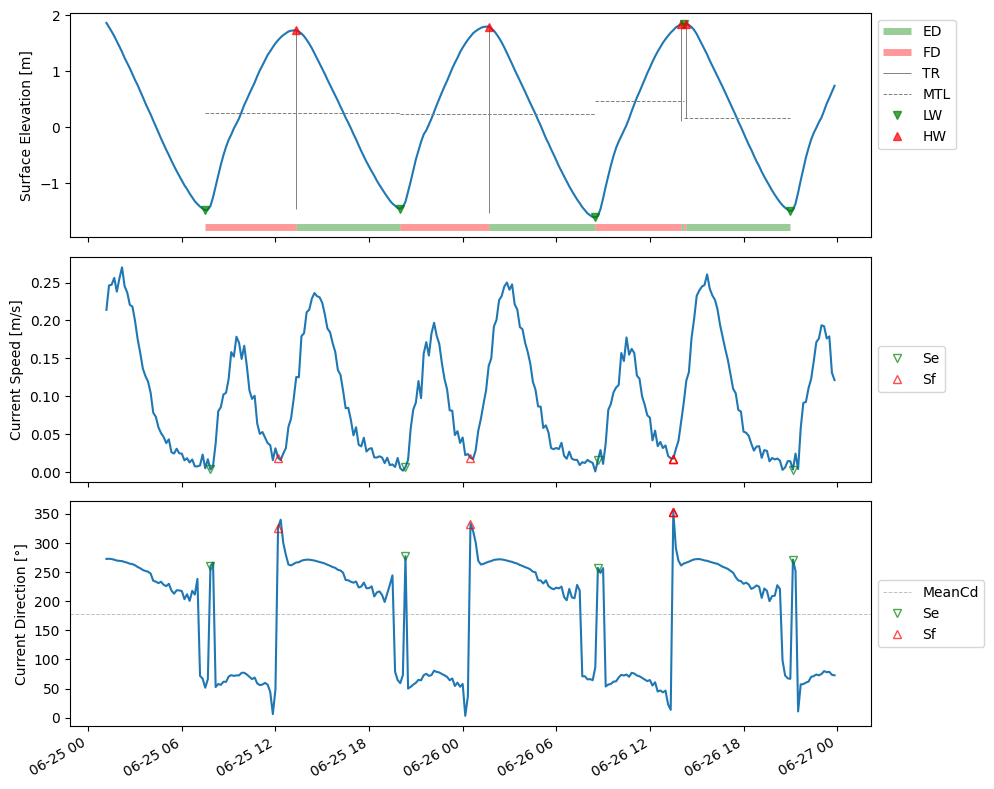

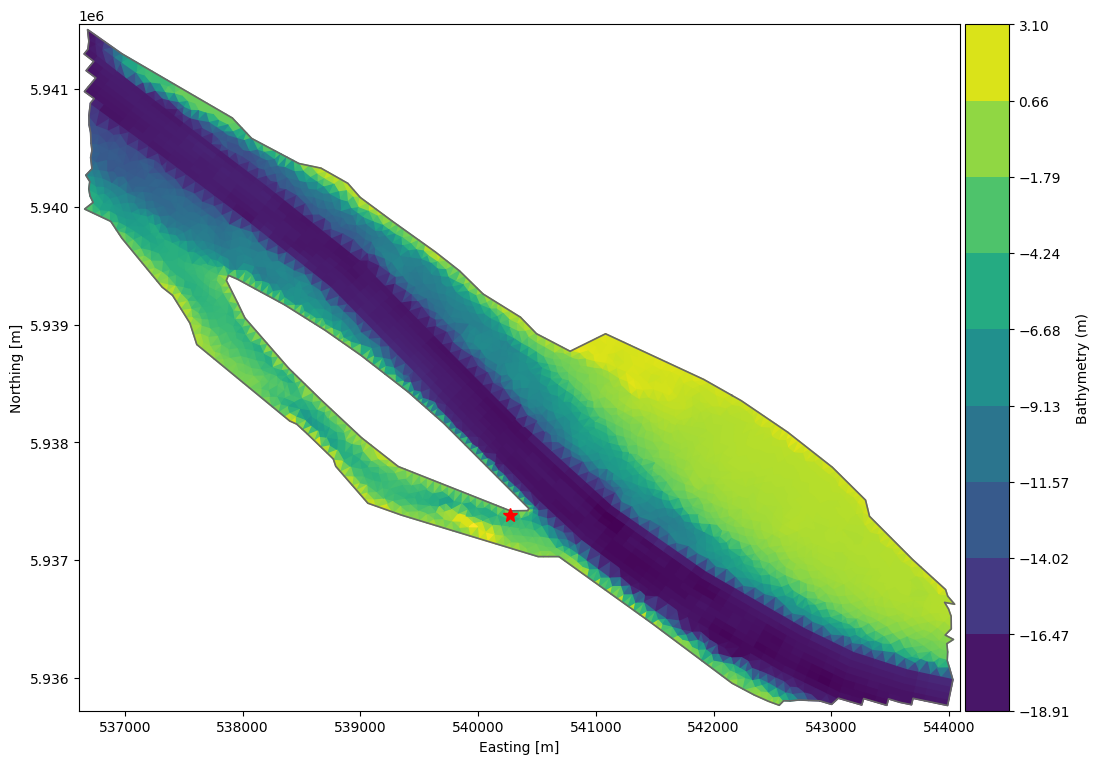

NonMatchingSlackError
slack points could not be matched to HWLWs. 
length of slack: 9
length of HWLWs: 9
Sanity CS: False
Sanity CD: False

Error Overview:
FallsPartiallyDryError     1   1.9 %
FallsPartiallyWetError     0   0.0 %
FallsWetError              0   0.0 %
NonAlternatingHWLWsError   0   0.0 %
NotEnoughWaterError       52  98.1 %
NotEnoughTidesError        0   0.0 %
NonMatchingSlackError      0   0.0 %
CurrentsToNoisyError       0   0.0 %
UnknownError               0   0.0 %


NonMatchingSlackError: slack points could not be matched to HWLWs. 
length of slack: 9
length of HWLWs: 9
Sanity CS: False
Sanity CD: False

In [25]:
tidal_area = TidalArea(identifier = "example",
                    surface_elevation = ds.Surface_elevation,
                    current_speed = ds.Current_speed,
                    current_direction = ds.Current_direction,
                    raise_error_types = NonMatchingSlackError,
                    verbose = True,
                    skip_n_errors = 1,
                    SE_DIF = None, # you will later why we do this
                    ) 

### Parameter Tuning

We can observe that the algorithm identifies multiple high tides for the last tide, indicating that the used parameters are not sufficient for accurate analysis.  
In the above calculations, we set the `SE_DIF` parameter to `None` to overwrite the default, to trigger some errors. The parameter specifies the minimum distance between two consecutive peaks (or troughs) in the surface elevation to detect the HTLTs (high tides and low tides). The value should be set to slightly less than the expected duration of an ebb or flood. The default is 2 hours, which works well for most cases. We will set the parameter back to the default and check the results.

Additionally, we want the peaks to have a prominence of at least 2 meters, so we set `SE_PROM` to 0.5 meters as an extra security measure. The tidal range in this area typically ranges from 3-4 meters, but in calmer basins, it can be smaller, especially with low inflow and outflow. By setting `SE_PROM` to 0.5 meters, we account for these regions with smaller tidal ranges.


In [ ]:
tidal_area = TidalArea(identifier = "example",
                    surface_elevation = ds.Surface_elevation,
                    current_speed = ds.Current_speed,
                    current_direction = ds.Current_direction,
                    raise_error_types = NonMatchingKenterError,
                    verbose = True,
                    skip_n_errors = 1,
                    SE_DIF = pd.Timedelta("2h"),
                    SE_PROM = 0.5,
                    )

NameError: name 'NonMatchingKenterError' is not defined

### Inspecting the Results
To view the calculated tidal characteristics we can create a mikeio dataset with the tidal characteristics saved as dataarrays.
We can can also plot the individual dataarrays.

<mikeio.Dataset>
dims: (element:4963)
time: 2022-06-26 00:25:00 (time-invariant)
geometry: Dfsu2D (4963 elements, 2999 nodes)
number of items: 11
[MHW <Surface Elevation> (meter), MLW <Surface Elevation> (meter), TR <Surface Elevation> (meter), MAXECS <Current Speed> (meter per sec), MAXFCS <Current Speed> (meter per sec), MEANECS <Current Speed> (meter per sec), MEANFCS <Current Speed> (meter per sec), ED <Time> (hour), FD <Time> (hour), ECD <Time> (hour), FCD <Time> (hour)]


<Axes: title={'center': '2022-06-26 00:25:00'}, xlabel='Easting [m]', ylabel='Northing [m]'>

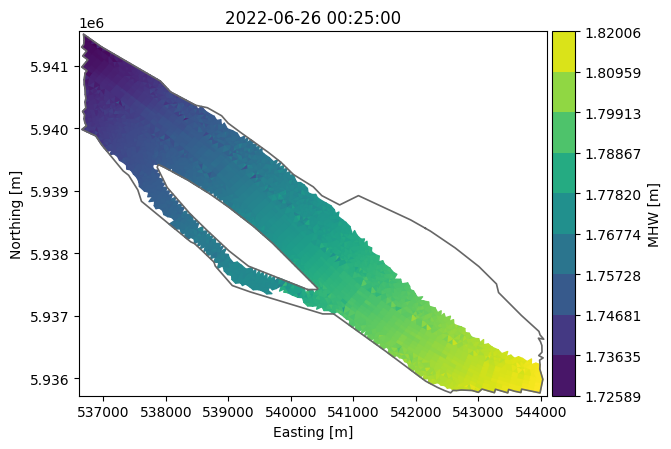

In [ ]:
ds = tidal_area.create_output_dataset()
print(ds)
print(ds.items)

ds.MHW.plot()

### Saving the Results

Once you are satisfied with the results, you can rerun the TidalArea analysis with the `save_path` argument. This will automatically save the following files:  
- **A `.dfsu` file**: Contains the calculated tidal characteristics for each element.  
- **A `.dill` object**: A serialized file (similar to `.pickle`) that saves the state of the `TidalArea` class for future use.  

If the calculation takes a long time and you prefer not to rerun it just for saving, you can enable saving by default or just call the save() function of the TidalArea object.  

In [ ]:
tidal_area.save_path = Path("../tests/data")
tidal_area.save()

### Inspecting single elements

If you are interested in inspecting the time series of an element at a specific location, you can retrieve the element ID using its coordinates. Once the ID is obtained, you can:  
- **Plot the element on the map** using the `plot_element_on_map` function.  
- **Save the time series** of the element to variables for further inspection.  

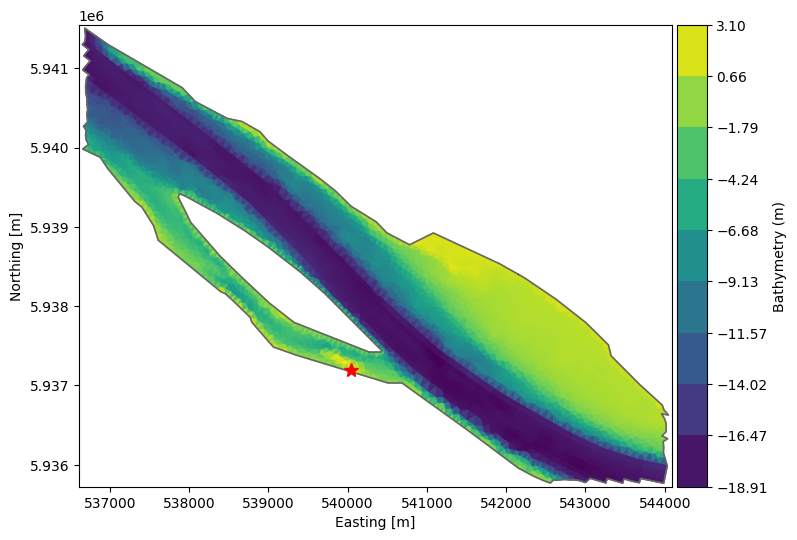

In [ ]:
element = tidal_area.surface_elevation.data.geometry.find_nearest_elements(x=540000, y=5937000)
ax = tidal_area.plot_element_on_map(element, figsize = (9, 6), show=True)
ax.set_title("")
element_se = tidal_area.surface_elevation.data.isel(element=element)
element_cs = tidal_area.current_speed.data.isel(element=element)
element_cd = tidal_area.current_direction.data.isel(element=element)

### Performing Tidal Analysis on a Single Element or on a .dfs0 File

The `TidalSeries` object, which operates in the background of the `TidalArea`, performs the actual analysis for each element. It can be used independently of the `TidalArea` object, taking just the three time series as input. These time series are `mikeio.DataArray` objects, so you can also load them from a `.dfs0` file.

In this example, we call the `TidalSeries` using the element time series that we have previously obtained.  

If `error_support` is set to `True` and an error occurs, the time series plots and tidal characteristics will be displayed up to the point where the error was raised. This helps in fine-tuning the parameters for a more accurate analysis on an element-by-element basis.

You can use the same parameters as those in the `TidalArea` analysis, but you're free to adjust them within meaningful ranges to improve the results.

A full description of the available parameters can be found in the README.md.  

TidalErrors(FallsPartiallyDryError=False, FallsPartiallyWetError=False, FallsWetError=False, NonAlternatingHWLWsError=False, NotEnoughWaterError=False, NotEnoughTidesError=False, NoSlackPointsFound=False, NonMatchingSlackError=False, CurrentsToNoisyError=False, UnknownError=False)

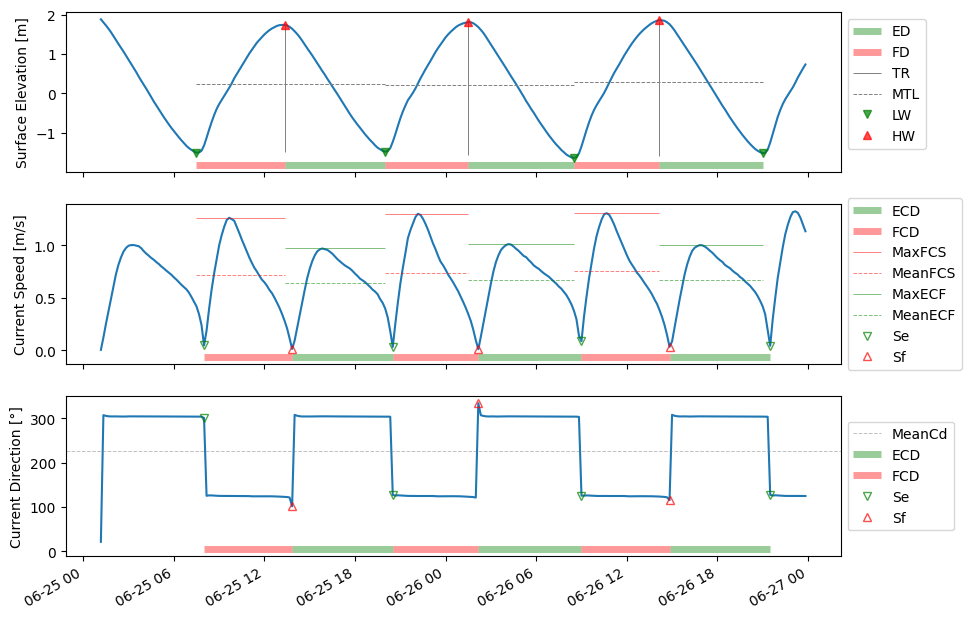

In [27]:
tidal_series = TidalSeries(surface_elevation=element_se,
            current_speed=element_cs, 
            current_direction=element_cd,
            SE_DIF = tidal_area.SE_DIF,
            SE_PROM = tidal_area.SE_PROM,
            CS_DIF = tidal_area.CS_DIF,
            CS_PROM = tidal_area.CS_PROM,
            MATCH_TOL = tidal_area.MATCH_TOL,
            MIN_TIDES = tidal_area.MIN_TIDES,
            THRSLD_NOWATER = tidal_area.THRSLD_NOWATER,
            THRSLD_WET_ERROR = tidal_area.THRSLD_WET_ERROR,
            THRSLD_WET_WARNING = tidal_area.THRSLD_WET_WARNING,
            TOL_WET_ERROR = tidal_area.TOL_WET_ERROR,
            ignore_error_types = "all_tidal",
            error_support = True)

tidal_series.plot_all_timeseries()
tidal_series.tidal_errors